<a href="https://colab.research.google.com/github/thunderunibolt/Aptos-test/blob/main/aptos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


In [ ]:
from google.colab import files
import zipfile


# Upload the zip file containing the folder
uploaded = files.upload()



Saving DenseNet121.h5 to DenseNet121.h5


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.49G/9.51G [00:47<00:00, 197MB/s]
100% 9.51G/9.51G [00:47<00:00, 214MB/s]


In [ ]:
!kaggle kernels output mathormad/aptos-resnet50-baseline

Output file downloaded to /content/Resnet50.h5
Output file downloaded to /content/Resnet50_bestqwk.h5
Output file downloaded to /content/submission.csv
Output file downloaded to /content/training_log.csv
Kernel log downloaded to /content/aptos-resnet50-baseline.log 


In [ ]:
# prompt: unzip a file /content/aptos2019-blindness-detection.zip

import zipfile

with zipfile.ZipFile('/content/aptos2019-blindness-detection.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
import keras
import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import cv2
import os
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
print(os.listdir("/content"))

['.config', 'drive', 'test_images', 'train_images', 'sample_submission.csv', 'aptos2019-blindness-detection.zip', 'kaggle.json', 'train.csv', 'test.csv', 'sample_data']


In [ ]:
# borrowed from https://www.kaggle.com/mathormad/aptos-resnet50-baseline
class QWKCallback(Callback):
    def __init__(self,validation_data):
        super(Callback, self).__init__()
        self.X = validation_data[0]
        self.Y = validation_data[1]
        self.history = []
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.X)
        score = cohen_kappa_score(np.argmax(self.Y,axis=1),np.argmax(pred,axis=1),labels=[0,1,2,3,4],weights='quadratic')
        print("Epoch {} : QWK: {}".format(epoch,score))
        self.history.append(score)
        if score >= max(self.history):
            print('saving checkpoint: ', score)
            self.model.save('/content/Resnet50_bestqwk.h5')

In [ ]:
# borrowed from https://github.com/yu4u/mixup-generator
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
def load_raw_images_df(data_frame,filenamecol,labelcol,img_size,n_classes):
    n_images = len(data_frame)
    X = np.empty((n_images,img_size,img_size,3))
    Y = np.zeros((n_images,n_classes))
    for index,entry in data_frame.iterrows():
        Y[index,entry[labelcol]] = 1 # one hot encoding of the label
        # Load the image and resize
        img = cv2.imread(entry[filenamecol])
        X[index,:] = cv2.resize(img, (img_size, img_size))
        X[index,:] = X[index,:] / 255.0
    return X,Y

In [ ]:
batch_size = 32
img_size = 224

<Axes: >

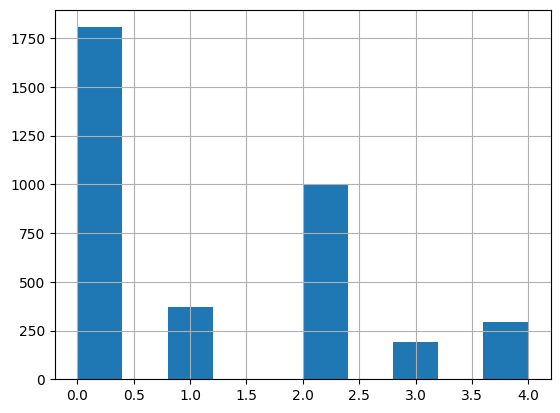

In [ ]:
train_raw_data = pd.read_csv("/content/train.csv")
train_raw_data["filename"] = train_raw_data["id_code"].map(lambda x:os.path.join("/content/train_images",x+".png"))
train_raw_data.diagnosis.hist() # See the distribution of the classes
# train_raw_data.dtypes

# # train_data["diagnosis"] = train_data["diagnosis"].astype(str)
# # print(train_data.head())
# # print(train_data.diagnosis.unique()) # Look at different types of classes
# # labels = list(map(str,range(5)))
# # print(labels)

In [ ]:
label_title = {"0" : "No DR","1" : "Mild","2" : "Moderate","3" :"Severe","4" : "Proliferative DR"}
class_labels=["No DR","Mild","Moderate","Severe","Proliferative DR"]

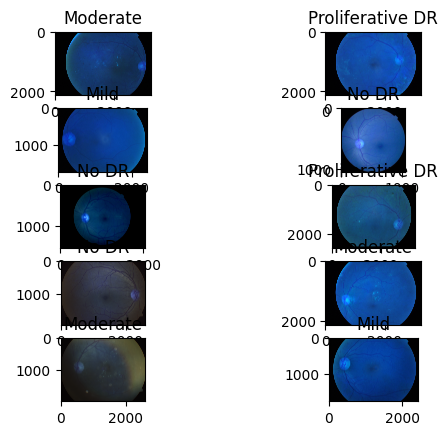

In [ ]:
figure, ax = plt.subplots(5,2)
ax = ax.flatten()
for i,row in train_raw_data.iloc[0:10,:].iterrows():
    ax[i].imshow(cv2.imread(os.path.join("/content/train_images",row["id_code"]+".png")))
    ax[i].set_title(label_title[str(row["diagnosis"])])

In [ ]:
train_df,val_df = train_test_split(train_raw_data,random_state=42,shuffle=True,test_size=0.333)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)

In [ ]:
X_train,Y_train = load_raw_images_df(train_df,"filename","diagnosis",img_size,5)
X_val,Y_val = load_raw_images_df(val_df,"filename","diagnosis",img_size,5)

In [ ]:
!pip install --upgrade scikit-learn
import sklearn
print(sklearn.__version__) # Verify the version is 0.20 or higher

# If you are using an older version of scikit-learn, use this code instead:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train_labels), y=Y_train_labels)
cls_wt_dict = dict(enumerate(class_weights))
print(cls_wt_dict)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 54.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
1.2.2
{0: 0.40397022332506205, 1: 1.9304347826086956, 2: 0.7333333333333333, 3: 3.7282442748091604, 4: 2.6688524590163936}


In [ ]:
datagen = ImageDataGenerator(

            zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)
training_generator = MixupGenerator(X_train, Y_train, batch_size=batch_size, alpha=0.2, datagen=datagen)()

In [ ]:
def buildModel():
    DenseNet121_model = DenseNet121(include_top=False,weights=None,input_tensor=keras.layers.Input(shape=(img_size,img_size,3)))
    DenseNet121_model.load_weights('/content/DenseNet-BC-121-32-no-top.h5')
#     model = keras.Sequential()

#     model.add(keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'same',activation ='relu',
#                       input_shape = (img_size,img_size,3)))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

#     model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(keras.layers.Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(keras.layers.Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(keras.layers.Flatten())
#     model.add(keras.layers.Dense(units = 512, activation = 'relu'))
#     model.add(keras.layers.Dense(units = 5, activation = 'softmax'))

    p  = keras.layers.GlobalAveragePooling2D()(DenseNet121_model.output)
#     fl = keras.layers.Flatten()(p)
#     d2 = keras.layers.Dense(units = 1024, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.001))(p)
#     d1 = keras.layers.Dense(units = 512, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.001))(d2)
    d11 = keras.layers.Dense(units = 256, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.0001))(p)
    o1 = keras.layers.Dense(units = 5, activation = 'softmax')(d11)
    model = keras.models.Model(inputs = DenseNet121_model.input,outputs = o1)
    # Use the 'learning_rate' argument instead of 'lr'
    # Use the 'decay' argument within the 'schedule' of 'learning_rate'
    sgd = keras.optimizers.SGD(learning_rate=keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.9), momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,loss='categorical_crossentropy', metrics = ['accuracy'])
    print(model.summary())
    return model

In [ ]:
mymodel = buildModel()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
EPOCHS = 50
earlystop = keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
checkpoint = keras.callbacks.ModelCheckpoint('/content/DenseNet121.h5', monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)
qwk = QWKCallback((X_val,Y_val))
mycallbacks = [earlystop, learning_rate_reduction,checkpoint,qwk]

In [ ]:
print(qwk)

In [ ]:
# Warm up the model with class weights
EPOCHS = 10
history = mymodel.fit_generator(training_generator,steps_per_epoch = X_train.shape[0] // batch_size,epochs = EPOCHS,
                         validation_data = (X_val,Y_val),
                         validation_steps = 10,
                         workers = 2,use_multiprocessing=True,
                         verbose=2, callbacks=mycallbacks,
                         class_weight=cls_wt_dict)

<ipython-input-41-29dfe5df4a50>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = mymodel.fit_generator(training_generator,steps_per_epoch = X_train.shape[0] // batch_size,epochs = EPOCHS,


Epoch 1/10


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Epoch 1: val_loss improved from inf to 2.84376, saving model to /content/DenseNet121.h5
39/39 [==============================] - 21s 482ms/step
Epoch 0 : QWK: 0.13841089197402134
saving checkpoint:  0.13841089197402134


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


76/76 - 295s - loss: 1.2354 - accuracy: 0.6690 - val_loss: 2.8438 - val_accuracy: 0.1680 - lr: 0.0100 - 295s/epoch - 4s/step
Epoch 2/10



Epoch 2: val_loss improved from 2.84376 to 1.72628, saving model to /content/DenseNet121.h5
39/39 [==============================] - 19s 482ms/step
Epoch 1 : QWK: 0.4108096238458955
saving checkpoint:  0.4108096238458955


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


76/76 - 260s - loss: 1.2608 - accuracy: 0.6213 - val_loss: 1.7263 - val_accuracy: 0.3221 - lr: 0.0100 - 260s/epoch - 3s/step
Epoch 3/10



Epoch 3: val_loss did not improve from 1.72628
39/39 [==============================] - 19s 478ms/step
Epoch 2 : QWK: 0.4694315010123503
saving checkpoint:  0.4694315010123503


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


76/76 - 257s - loss: 1.1208 - accuracy: 0.6949 - val_loss: 1.8775 - val_accuracy: 0.5885 - lr: 0.0100 - 257s/epoch - 3s/step
Epoch 4/10



Epoch 4: val_loss improved from 1.72628 to 0.82696, saving model to /content/DenseNet121.h5
39/39 [==============================] - 18s 455ms/step
Epoch 3 : QWK: 0.7559104060933735
saving checkpoint:  0.7559104060933735


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


76/76 - 255s - loss: 1.1364 - accuracy: 0.7056 - val_loss: 0.8270 - val_accuracy: 0.7385 - lr: 0.0100 - 255s/epoch - 3s/step
Epoch 5/10



Epoch 5: val_loss did not improve from 0.82696
39/39 [==============================] - 18s 451ms/step
Epoch 4 : QWK: 0.650779430953639
76/76 - 254s - loss: 1.1205 - accuracy: 0.7039 - val_loss: 1.1507 - val_accuracy: 0.5934 - lr: 0.0100 - 254s/epoch - 3s/step
Epoch 6/10



Epoch 6: val_loss did not improve from 0.82696
39/39 [==============================] - 17s 440ms/step
Epoch 5 : QWK: 0.47189237789804817
76/76 - 251s - loss: 1.1429 - accuracy: 0.6990 - val_loss: 1.4437 - val_accuracy: 0.5549 - lr: 0.0100 - 251s/epoch - 3s/step
Epoch 7/10



Epoch 7: val_loss did not improve from 0.82696
39/39 [==============================] - 17s 442ms/step
Epoch 6 : QWK: 0.4566403116140111
76/76 - 249s - loss: 1.0493 - accuracy: 0.7064 - val_loss: 1.4360 - val_accuracy: 0.6303 - lr: 0.0099 - 249s/epoch - 3s/step
Epoch 8/10



Epoch 8: val_loss did not improve from 0.82696
39/39 [==============================] - 17s 427ms/step
Epoch 7 : QWK: 0.16102811511016557
76/76 - 247s - loss: 1.0842 - accuracy: 0.6937 - val_loss: 1.3897 - val_accuracy: 0.5320 - lr: 0.0099 - 247s/epoch - 3s/step
Epoch 9/10



Epoch 9: val_loss did not improve from 0.82696
39/39 [==============================] - 16s 411ms/step
Epoch 8 : QWK: 0.635182445009012
76/76 - 242s - loss: 1.0997 - accuracy: 0.7192 - val_loss: 1.1392 - val_accuracy: 0.6295 - lr: 0.0099 - 242s/epoch - 3s/step
Epoch 10/10



Epoch 10: val_loss improved from 0.82696 to 0.77094, saving model to /content/DenseNet121.h5
39/39 [==============================] - 18s 462ms/step
Epoch 9 : QWK: 0.7920595396390262
saving checkpoint:  0.7920595396390262


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


76/76 - 247s - loss: 1.1026 - accuracy: 0.7081 - val_loss: 0.7709 - val_accuracy: 0.7623 - lr: 0.0099 - 247s/epoch - 3s/step


In [ ]:
EPOCHS = 50
history = mymodel.fit_generator(training_generator,steps_per_epoch = X_train.shape[0] // batch_size,epochs = EPOCHS,
                         validation_data = (X_val,Y_val),
                         validation_steps = 10,
                         workers = 2,use_multiprocessing=True,
                         verbose=2, callbacks=mycallbacks)

<ipython-input-42-7f5d09d549c1>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = mymodel.fit_generator(training_generator,steps_per_epoch = X_train.shape[0] // batch_size,epochs = EPOCHS,


Epoch 1/50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Epoch 1: val_loss improved from 0.77094 to 0.68672, saving model to /content/DenseNet121.h5
39/39 [==============================] - 18s 451ms/step
Epoch 0 : QWK: 0.7928939707481323
saving checkpoint:  0.7928939707481323


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


76/76 - 415s - loss: 0.7181 - accuracy: 0.7767 - val_loss: 0.6867 - val_accuracy: 0.7795 - lr: 0.0099 - 415s/epoch - 5s/step
Epoch 2/50



Epoch 2: val_loss did not improve from 0.68672
39/39 [==============================] - 17s 447ms/step
Epoch 1 : QWK: 0.7758136259642104
76/76 - 253s - loss: 0.7171 - accuracy: 0.7775 - val_loss: 0.8889 - val_accuracy: 0.7582 - lr: 0.0099 - 253s/epoch - 3s/step
Epoch 3/50



Epoch 3: val_loss did not improve from 0.68672
39/39 [==============================] - 18s 457ms/step
Epoch 2 : QWK: 0.7894833648340324
76/76 - 248s - loss: 0.6647 - accuracy: 0.8014 - val_loss: 1.0191 - val_accuracy: 0.7672 - lr: 0.0099 - 248s/epoch - 3s/step
Epoch 4/50



Epoch 4: val_loss improved from 0.68672 to 0.64636, saving model to /content/DenseNet121.h5
39/39 [==============================] - 17s 419ms/step
Epoch 3 : QWK: 0.8589889400146032
saving checkpoint:  0.8589889400146032


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


76/76 - 245s - loss: 0.6765 - accuracy: 0.8002 - val_loss: 0.6464 - val_accuracy: 0.7795 - lr: 0.0099 - 245s/epoch - 3s/step
Epoch 5/50



Epoch 5: val_loss did not improve from 0.64636
39/39 [==============================] - 19s 485ms/step
Epoch 4 : QWK: 0.8214789889326797
76/76 - 248s - loss: 0.6444 - accuracy: 0.8178 - val_loss: 0.6599 - val_accuracy: 0.7820 - lr: 0.0099 - 248s/epoch - 3s/step
Epoch 6/50



Epoch 6: val_loss did not improve from 0.64636
39/39 [==============================] - 17s 435ms/step
Epoch 5 : QWK: 0.8124041484742662
76/76 - 246s - loss: 0.6408 - accuracy: 0.8141 - val_loss: 0.8349 - val_accuracy: 0.7828 - lr: 0.0099 - 246s/epoch - 3s/step
Epoch 7/50



Epoch 7: val_loss did not improve from 0.64636
39/39 [==============================] - 19s 491ms/step
Epoch 6 : QWK: 0.686441036060152
76/76 - 247s - loss: 0.6402 - accuracy: 0.8039 - val_loss: 0.7463 - val_accuracy: 0.7426 - lr: 0.0099 - 247s/epoch - 3s/step
Epoch 8/50



Epoch 8: val_loss did not improve from 0.64636
39/39 [==============================] - 17s 424ms/step
Epoch 7 : QWK: 0.7699412802332009
76/76 - 243s - loss: 0.6129 - accuracy: 0.8244 - val_loss: 0.8323 - val_accuracy: 0.7557 - lr: 0.0099 - 243s/epoch - 3s/step
Epoch 9/50



Epoch 9: val_loss did not improve from 0.64636
39/39 [==============================] - 17s 422ms/step
Epoch 8 : QWK: 0.8565222101798184
76/76 - 241s - loss: 0.6354 - accuracy: 0.8141 - val_loss: 0.7591 - val_accuracy: 0.7787 - lr: 0.0098 - 241s/epoch - 3s/step
Epoch 10/50



Epoch 10: val_loss did not improve from 0.64636
39/39 [==============================] - 16s 403ms/step
Epoch 9 : QWK: 0.8502197935861424
76/76 - 241s - loss: 0.6286 - accuracy: 0.8199 - val_loss: 0.7424 - val_accuracy: 0.7762 - lr: 0.0098 - 241s/epoch - 3s/step
Epoch 11/50



Epoch 11: val_loss did not improve from 0.64636
39/39 [==============================] - 19s 482ms/step
Epoch 10 : QWK: 0.7933487819651168
76/76 - 245s - loss: 0.6565 - accuracy: 0.8104 - val_loss: 0.8391 - val_accuracy: 0.7664 - lr: 0.0098 - 245s/epoch - 3s/step
Epoch 12/50



Epoch 12: val_loss did not improve from 0.64636
39/39 [==============================] - 17s 428ms/step
Epoch 11 : QWK: 0.8723028807064258
saving checkpoint:  0.8723028807064258


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


76/76 - 241s - loss: 0.6429 - accuracy: 0.8154 - val_loss: 0.6565 - val_accuracy: 0.7934 - lr: 0.0098 - 241s/epoch - 3s/step
Epoch 13/50



Epoch 13: val_loss did not improve from 0.64636
39/39 [==============================] - 16s 419ms/step
Epoch 12 : QWK: 0.8385493378427146
76/76 - 240s - loss: 0.6110 - accuracy: 0.8203 - val_loss: 0.7325 - val_accuracy: 0.7852 - lr: 0.0098 - 240s/epoch - 3s/step
Epoch 14/50



Epoch 14: val_loss did not improve from 0.64636
39/39 [==============================] - 17s 422ms/step
Epoch 13 : QWK: 0.8378058041096106
76/76 - 243s - loss: 0.6256 - accuracy: 0.8252 - val_loss: 0.7749 - val_accuracy: 0.8025 - lr: 0.0098 - 243s/epoch - 3s/step


In [ ]:
mymodel.save_weights("model.h5")

In [ ]:
Y_val_pred = mymodel.predict_on_batch(X_val)

In [ ]:
Y_val_pred_hot = np.argmax(Y_val_pred,axis=1)
Y_val_actual_hot = np.argmax(Y_val,axis=1)

Confusion matrix, without normalization
[[587   4   5   0   0]
 [ 18  50  48   0   1]
 [ 11  10 307   3   2]
 [  0   2  48   9   3]
 [  1   4  78   3  26]]


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

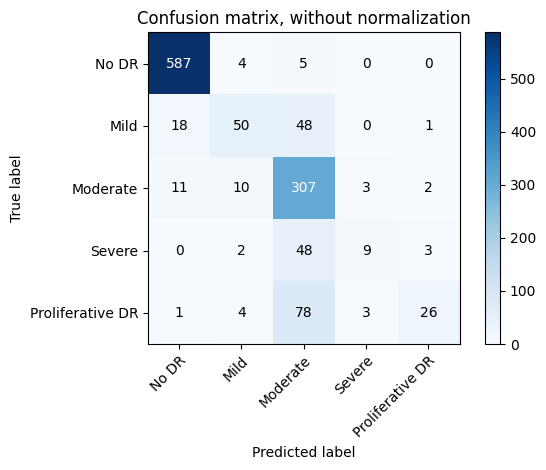

In [ ]:
plot_confusion_matrix(Y_val_actual_hot, Y_val_pred_hot, np.array(class_labels))

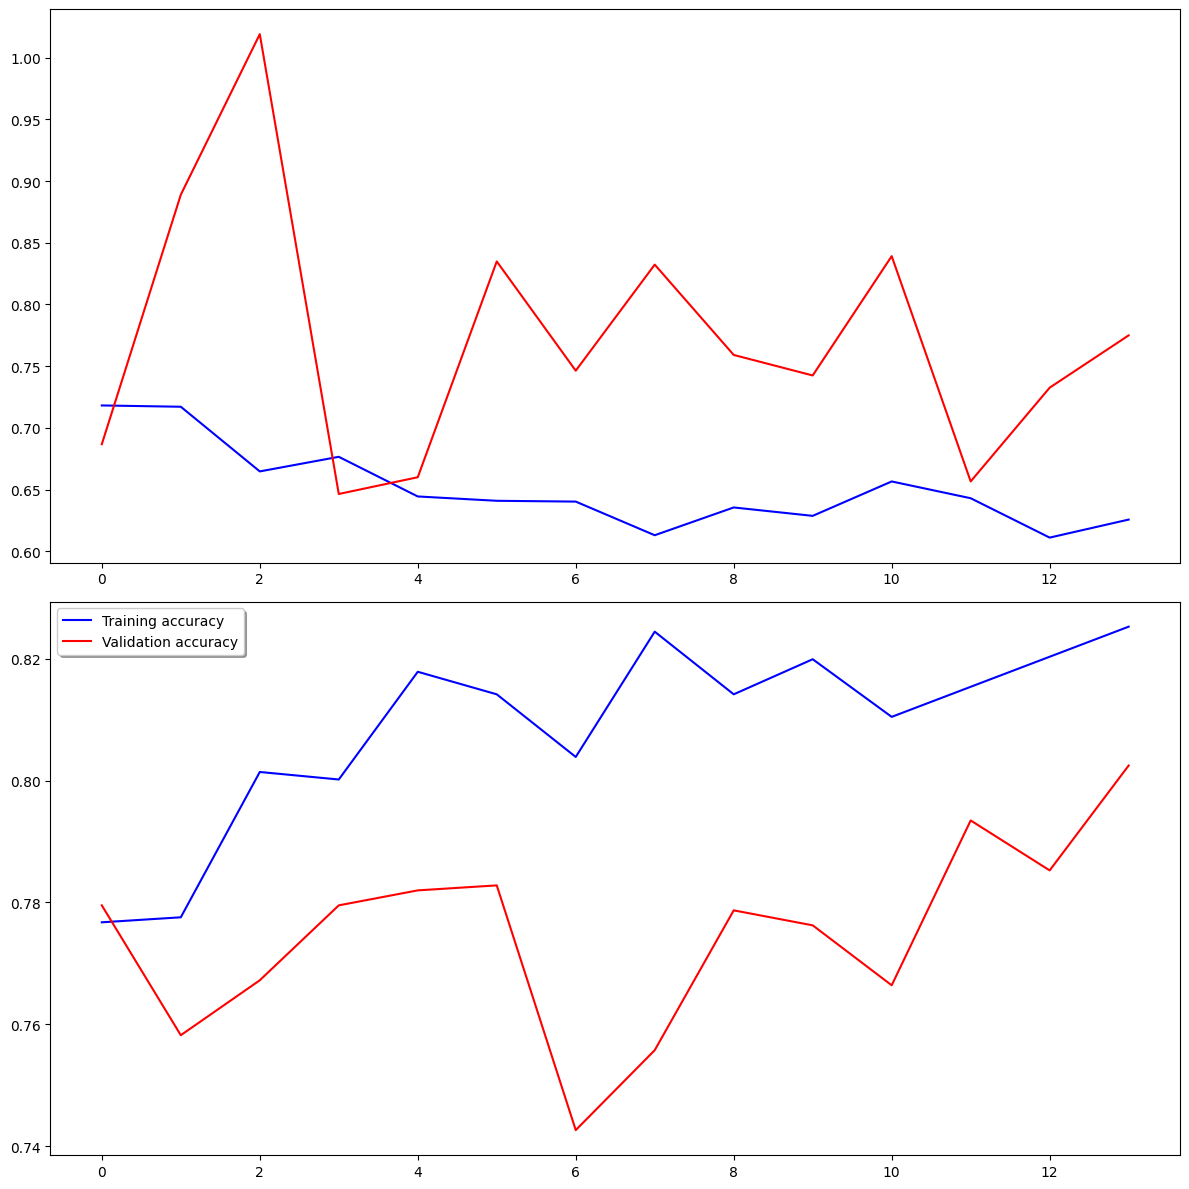

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
# ax1.set_xticks(np.arange(1, epochs, 1))
# ax1.set_yticks(np.arange(0, 1, 0.1))

# Use 'accuracy' instead of 'acc' for training accuracy
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
# ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
test_data = pd.read_csv("/content/test.csv")
test_data["filename"] = test_data["id_code"].map(lambda x:x+".png")
test_data.head()

,id_code,filename
0,0005cfc8afb6,0005cfc8afb6.png
1,003f0afdcd15,003f0afdcd15.png
2,006efc72b638,006efc72b638.png
3,00836aaacf06,00836aaacf06.png
4,009245722fa4,009245722fa4.png


In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
        dataframe=test_data,
        directory = "/content/test_images",
        x_col="filename",
        y_col=None,
        target_size = (img_size,img_size),
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )

Found 1928 validated image filenames.


In [ ]:
predictions = mymodel.predict_generator(test_generator, steps = len(test_generator.filenames))


<ipython-input-53-b1f6edc7a54b>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = mymodel.predict_generator(test_generator, steps = len(test_generator.filenames))


In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"id_code":filenames,
                      "diagnosis":np.argmax(predictions,axis=1)})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv("submission1.csv",index=False)

array([0, 2, 3])

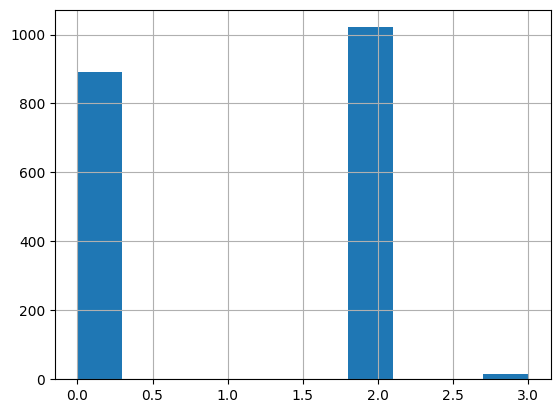

In [ ]:
results.diagnosis.hist()
results.diagnosis.unique()

Checking model file in /content/ directory:
1/1 [==============================] - 2s 2s/step
Predicted class: Severe


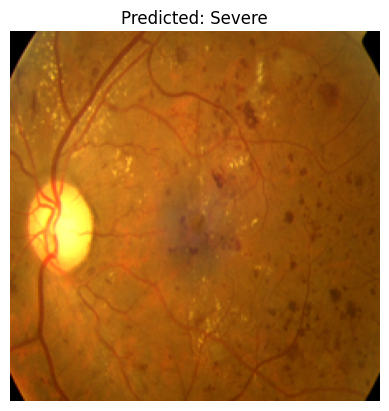

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Verify the path to your model
print("Checking model file in /content/ directory:")
os.system("ls /content/")

# Path to your model
model_path = '/content/model.h5'

# Check if the model file exists
if not os.path.exists(model_path):
    print(f"Error: Model file not found at {model_path}")
else:
    # Load the model
    model = tf.keras.models.load_model(model_path)

    # Path to the test image
    image_path = '/content/test_images/01499815e469.png'
    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((224, 224))  # Resize the image to match the input size expected by the model
    img_array = np.array(img) / 255.0  # Normalize the image

    # Expand dimensions to match the input shape of the model
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_array)

    # Get the predicted class
    predicted_class = np.argmax(predictions)

    # Class labels
    class_labels = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]
    predicted_label = class_labels[predicted_class]

    # Print the predicted class label
    print(f"Predicted class: {predicted_label}")

    # Display the image
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()


Checking model file in /content/ directory:


Saving a958957485f1.png to a958957485f1.png
1/1 [==============================] - 2s 2s/step
Predicted class: No DR


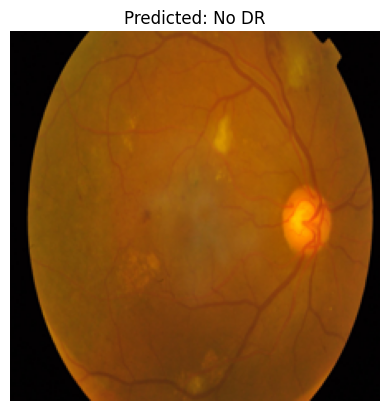

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files

# Verify the path to your model
print("Checking model file in /content/ directory:")
os.system("ls /content/")

# Path to your model
model_path = '/content/model.h5'

# Check if the model file exists
if not os.path.exists(model_path):
    print(f"Error: Model file not found at {model_path}")
else:
    # Load the model
    model = tf.keras.models.load_model(model_path)

    # Upload an image
    uploaded = files.upload()

    # Ensure only one file is uploaded
    if len(uploaded) != 1:
        print("Please upload exactly one image file.")
    else:
        # Get the uploaded file name
        image_path = list(uploaded.keys())[0]

        # Load and preprocess the image
        img = Image.open(image_path)
        img = img.resize((224, 224))  # Resize the image to match the input size expected by the model
        img_array = np.array(img) / 255.0  # Normalize the image

        # Expand dimensions to match the input shape of the model
        img_array = np.expand_dims(img_array, axis=0)

        # Make predictions
        predictions = model.predict(img_array)

        # Get the predicted class
        predicted_class = np.argmax(predictions)

        # Class labels
        class_labels = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]
        predicted_label = class_labels[predicted_class]

        # Print the predicted class label
        print(f"Predicted class: {predicted_label}")

        # Display the image
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()


In [ ]:
mymodel.save('/content/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
